# Visualizing models using Tensorboard Tutorial

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Setting up the Dataset

In [3]:
#transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

#datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

#dataloaders
trainloader = torch.utils.data.DataLoader(trainset,
    batch_size=4,
    shuffle=True,
    num_workers=12)
testloader = torch.utils.data.DataLoader(testset,
    batch_size=4,
    shuffle=False,
    num_workers=12)

#Classes names
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


## Auxiliar function for showing an image

In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 #unnormalize image
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

## Setting up the model

In [5]:
class Flatten(nn.Module):
    def forward(self, X):
        return X.view(X.size()[0], -1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = [
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        ]

        self.layers = nn.Sequential(*self.layers)

    def forward(self, X):
        return self.layers(X)
    
net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Setting up Tensorboard

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./runs/fashion_mnist_experiment_1')

## Writting to Tensorboard

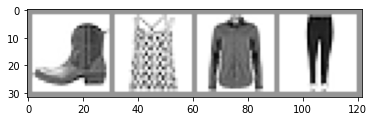

In [8]:
#get some images
trainiter = iter(trainloader)
images, labels = trainiter.next()

#create image grid
img_grid = torchvision.utils.make_grid(images)

#show images
matplotlib_imshow(img_grid, one_channel=True)

#add to tensorboard
writer.add_image('example_images_fashion_mnist', img_grid)

## Adding the model graph

*Unlike on tensorflow, we need to add the model graph manually

In [9]:
writer.add_graph(net, images)

## Projectin the images to a lower dimension space

In [10]:
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

#select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

#get the class labels for each image
class_labels = [classes[lab] for lab in labels]

#log embeddings
features = images.view(-1, 28*28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))

## Tracking Model Training

In [11]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained network and a list of images
    '''
    output = net(images)
    #convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images and labels from a batch, that shows the network's top prediction along with its probability, alongside the actual label, coloring this information based on whether the prediction was correct or not. 
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    #plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(f"{classes[preds[idx]]}, {probs[idx]*100}\n(label: {classes[labels[idx]]}", color=("green" if preds[idx]==labels[idx].item() else "red"))
    
    return fig

In [13]:
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        #get the inputs
        inputs, labels = data
        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        outputs = net(inputs)
        #loss
        loss = criterion(outputs, labels)
        #backward + gradient descent
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999: #every 1000 mini-batches
            #plot the training loss as a scalar
            writer.add_scalar('training loss', running_loss/1000, epoch * len(trainloader) + i)
            #shows the model's prediction on a random mini-batch
            writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels), global_step=epoch*len(trainloader)+i)
            running_loss = 0.0

## Checking model performance using PR-Curves

In [14]:
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

#pr curve plotting
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index], tensorboard_preds, tensorboard_probs, global_step=global_step)

#plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [15]:
writer.close()